In [68]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [69]:
def get_image(path,image_transform,size=(300,300)):
    image = Image.open(path)
    image = image.resize(size,Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)
    
def get_gram(m):
    """
    m is of shape (1,C,H,W)
    """
    bs,c,h,w = m.size()
    m = m.view(c,h*w) # rows,columns
    # matrix multiply
    m = torch.mm(m,m.t())
    return m

def denormalize_img(inp):
    inp = inp.numpy().transpose((1,2,0)) # Transposing C,H,W ---> (H,W,C)
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    # Now denormalizing
    inp = std * inp + mean # When normalizing --> input - mean / standard_deviation
    inp = np.clip(inp,0,1) # Limits the value in an array
    return inp
    

### Style loss , content loss

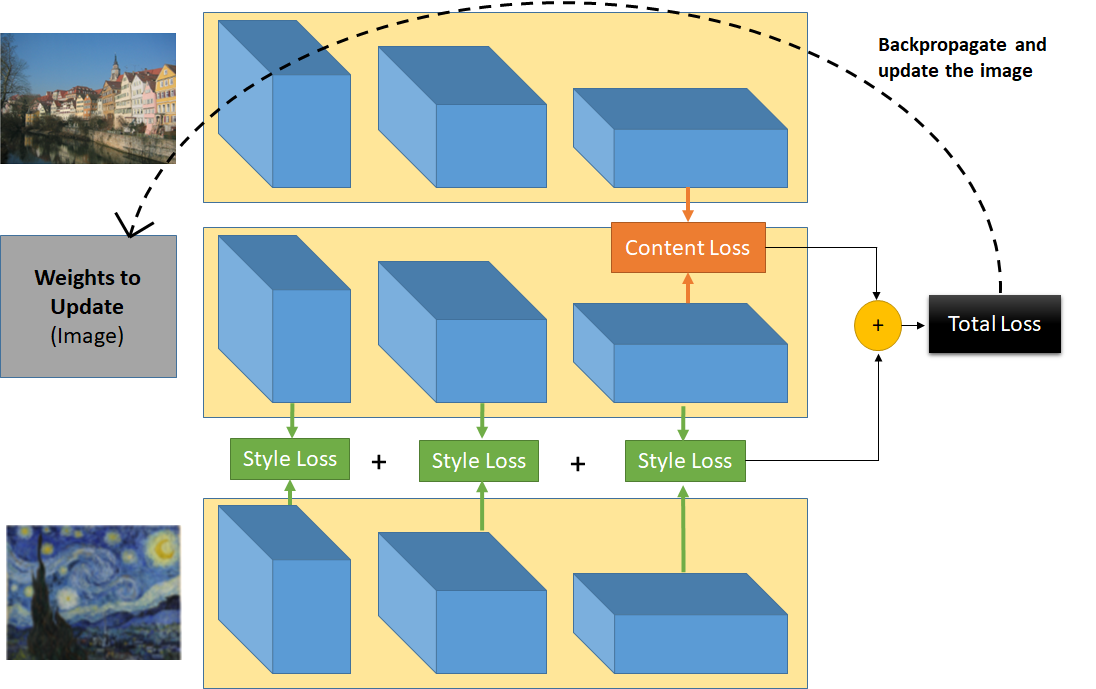

In [70]:
models.vgg16(pretrained = True).features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [71]:
models.vgg16(pretrained = True).features._modules.items()

odict_items([('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('1', ReLU(inplace=True)), ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('3', ReLU(inplace=True)), ('4', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('6', ReLU(inplace=True)), ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('8', ReLU(inplace=True)), ('9', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('11', ReLU(inplace=True)), ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('13', ReLU(inplace=True)), ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))), ('15', ReLU(inplace=True)), ('16', MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)), ('17', Conv2d(25

In [72]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor,self).__init__()
        self.selected_layers = [3,8,15,22] # All the taken layers are after relu activation fxn
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self,x):
        layer_features = []
        
        for layer_number,layer in self.vgg._modules.items():
            # Run i/p through that layer. I/p is x here
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
                
        return layer_features

In [73]:
img_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.485,0.456,0.406),std = (0.229,0.224,0.225))])
content_img = get_image('content_1.jpg',img_transform,size=(300,300))
style_img = get_image('style_1.jpg',img_transform,size = (300,300))
generated_img = content_img.clone()
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
# Create instance of the class
encoder = FeatureExtractor().to(device)

# Freeze the model
for p in encoder.parameters():
    p.requires_grad = False

/tmp/ipykernel_5767/1619916451.py:3: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize(size,Image.LANCZOS)


In [74]:
content_weight = 1
style_weight = 100

for epoch in range(50000):
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    content_loss = torch.mean((content_features[-1] - generated_features[-1]**2))
    
    style_loss = 0
    
    for gf,sf in zip(generated_features,style_features):# generative feature, style feature
        
        _,c,h,w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        # Add style loss on each iteration
        style_loss += torch.mean((gram_gf - gram_sf)**2)/ (c*h*w)
        
    loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))

Epoch [0]	Content Loss: -2.9462	Style Loss: 7609.9121
Epoch [10]	Content Loss: -3.2780	Style Loss: 6944.4385
Epoch [20]	Content Loss: -3.5965	Style Loss: 6186.2568
Epoch [30]	Content Loss: -3.7357	Style Loss: 5463.1387
Epoch [40]	Content Loss: -3.7277	Style Loss: 4819.7095
Epoch [50]	Content Loss: -3.6709	Style Loss: 4264.4854
Epoch [60]	Content Loss: -3.6089	Style Loss: 3793.8210
Epoch [70]	Content Loss: -3.5448	Style Loss: 3397.1521
Epoch [80]	Content Loss: -3.4758	Style Loss: 3062.4395
Epoch [90]	Content Loss: -3.4130	Style Loss: 2776.5093
Epoch [100]	Content Loss: -3.3589	Style Loss: 2529.2534
Epoch [110]	Content Loss: -3.3046	Style Loss: 2312.6731
Epoch [120]	Content Loss: -3.2546	Style Loss: 2120.7632
Epoch [130]	Content Loss: -3.2144	Style Loss: 1949.0553
Epoch [140]	Content Loss: -3.1832	Style Loss: 1794.0483
Epoch [150]	Content Loss: -3.1565	Style Loss: 1653.2230
Epoch [160]	Content Loss: -3.1329	Style Loss: 1524.7064
Epoch [170]	Content Loss: -3.1132	Style Loss: 1406.8220
Epo

In [75]:
inp = generated_img.detach().cpu()

In [76]:
inp.shape

torch.Size([1, 3, 300, 300])

In [77]:
import cv2

torch.Size([3, 300, 300])
<class 'numpy.ndarray'>


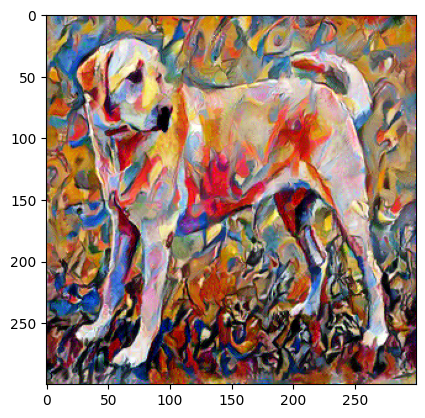

In [78]:
inp = generated_img.detach().cpu().squeeze()
print(inp.shape)
inp = denormalize_img(inp)
print(type(inp))
show = plt.imshow(inp)
# im = Image.fromarray(inp)
# inp.save("aa.jpg")

In [79]:
inp.shape

(300, 300, 3)

In [80]:
im = Image.fromarray((inp * 255).astype(np.uint8))

In [81]:
im.save("Image_dog_5000.jpg")

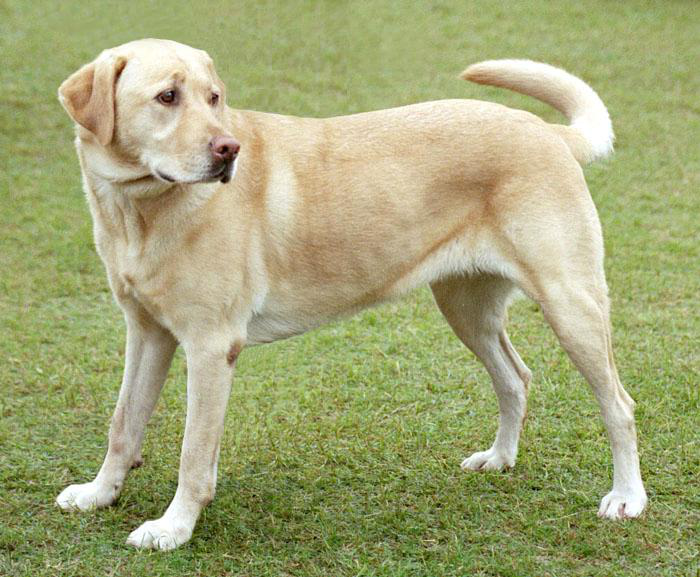

In [82]:
Image.open('content_1.jpg')

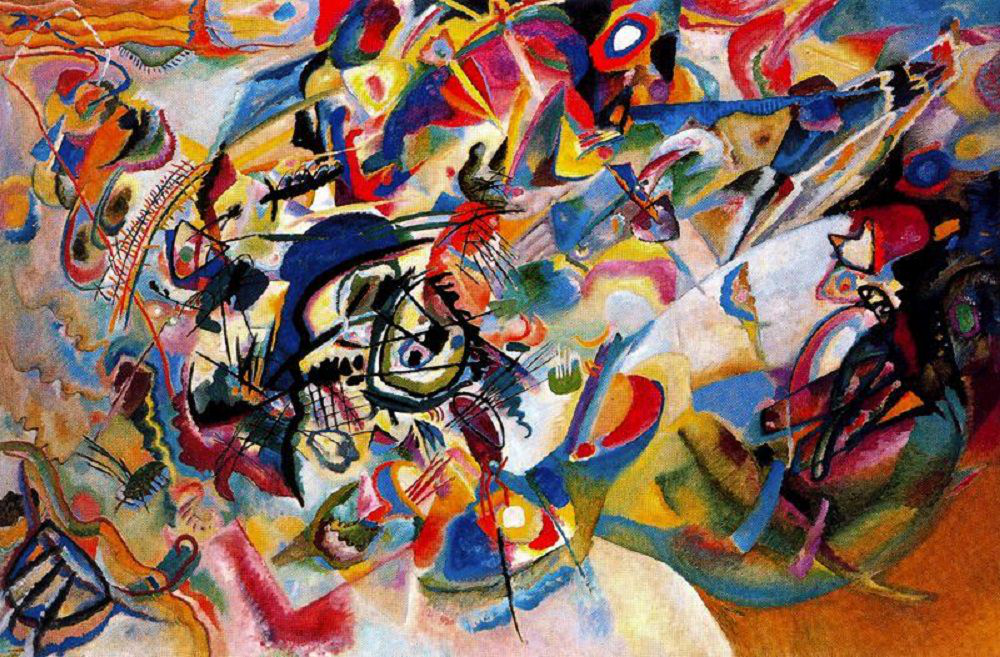

In [83]:
Image.open('style_1.jpg')